# DATA SAMPLING APPROACH

- This notebook aims at implementing the data sampling technique that is outlined in the data sampling word document file uisng python code and access via baby shark client

## Imports

In [6]:
import json
import os
import ast
from pathlib import Path
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import ast

#babyshark client to connect to elastic search indexes
from elasticsearch import Elasticsearch, RequestsHttpConnection
from dotenv import dotenv_values
from elaseco.elaseco import get_babyshark_client
from elasticsearch_dsl import Search, Q  # to generate elastic search queries
from elasticsearch.helpers import scan


%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Acess to Elastic Search

In [2]:
class MyConnection(RequestsHttpConnection):
    def __init__(self, *args, **kwargs):
        proxies = kwargs.pop("proxies", {})
        super(MyConnection, self).__init__(*args, **kwargs)
        self.session.proxies = proxies
        print(self.session.__dict__)
        print(self.session.proxies)

mc = MyConnection()
print(mc.__dict__)


# load credentials from .env
env_variables = dotenv_values()

babyshark_username = env_variables["BABYSHARK_USERNAME"]
babyshark_password = env_variables["BABYSHARK_PASSWORD"]

# EIOS research and innovation Elasticsearch API end-point web address
end_point = "https://portal.who.int:443/elasticsearch"

# username and password for basic http access authentication
credentials = (babyshark_username, babyshark_password)

# connect
client = Elasticsearch(
    end_point,
    http_auth=credentials,
    connection_class=MyConnection,
    proxies={"https": "http://fw-bln.rki.local:8020"},
    verify_certs=False,
    # basic_auth=credentials, # if using elastic_search >=8.0
)


{'headers': {'user-agent': 'elasticsearch-py/7.17.6 (Python 3.11.7)', 'accept-encoding': None}, 'auth': None, 'proxies': {}, 'hooks': {'response': []}, 'params': {}, 'stream': False, 'verify': True, 'cert': None, 'max_redirects': 30, 'trust_env': True, 'cookies': <RequestsCookieJar[]>, 'adapters': OrderedDict([('https://', <requests.adapters.HTTPAdapter object at 0x000001A156DE3E10>), ('http://', <requests.adapters.HTTPAdapter object at 0x000001A156DE3F90>)])}
{}
{'session': <requests.sessions.Session object at 0x000001A156DC3A10>, 'use_ssl': False, 'http_compress': False, 'scheme': 'http', 'hostname': 'localhost', 'port': 9200, 'host': 'http://localhost:9200', 'url_prefix': '', 'timeout': 10, 'meta_header': True, 'base_url': 'http://localhost:9200'}
{'headers': {'user-agent': 'elasticsearch-py/7.17.6 (Python 3.11.7)', 'accept-encoding': None}, 'auth': ('baby_shark', '!El4st1c@e105'), 'proxies': {'https': 'http://fw-bln.rki.local:8020'}, 'hooks': {'response': []}, 'params': {}, 'stream

c:\Users\NkwawirB\.conda\envs\data_explore\Lib\site-packages\elasticsearch\connection\http_requests.py:139: UserWarning: Connecting to https://portal.who.int:443 using SSL with verify_certs=False is insecure.
  warnings.warn(


## Helper Functions

In [81]:

#Extract data from a given index in Elastic search from a specific board.

def retrieve_and_save_elasticsearch_data(index_name, tags_query, size):

    """
    index_name (str): specifies the Elastic search index for which articles will be extracted
    tags_query
    
    """

    

    # Define the range query for the 'pubDate' field
    date_range_query = Q("range", **{
        "pubDate": {
            "gte": "2024-09-09T00:00:00",
            "lte": "2024-09-24T23:59:59"
        }
    })

    # Define the terms query for the 'tags' field based on input tags_query
    tags_query_elasticsearch =  tags_query

    # Combine the queries using a bool must query
    combined_query = Q("bool", must=[date_range_query, tags_query_elasticsearch])

    # Add the combined query to the search object
    search = Search(using=client, index=index_name).query(combined_query)

    # Specify the fields to include in the results
    fields_to_include = [
        "title", "translatedTitle", "description", "translatedDescription",
        "fullText", "translatedText", "rssItemId", "abstractiveSummary", 
        "translatedAbstractiveSummary"
    ]
    search = search.source(includes=fields_to_include)

    # Set the size of results to retrieve based on input size
    search = search[0:size]

    # Execute the search
    response = search.execute()

    # Convert the response hits to a list of dictionaries
    response_data = [hit.to_dict() for hit in response]

    # Extract the required columns for the CSV
    filtered_data = [{
        "_id": hit.get("_id", ""),
        "fullText": hit.get("fullText", ""),
        "description": hit.get("description", ""),
        "title": hit.get("title", ""),
        "rssItemId": hit.get("rssItemId", "")
    } for hit in response_data]

    # Create a DataFrame from the filtered data
    df = pd.DataFrame(filtered_data, columns=["_id", "fullText", "description", "title", "rssItemId"])

    #output_filename = f"uelasticsearch_results.csv"

    return df




## Extract Data Sample

### Sample query to extract articles from a specific board in ES using the ES Dev Tool user interface:

GET eios-items_2023-10/_search
{
  "query": {
    "bool": {
      "must": [
        {
          "range": {
            "pubDate": {
              "gte": "2023-10-11T00:00:00",
              "lte": "2023-10-11T23:59:59" 
            }
          }
        },
        {
          "terms": {
            "tags": [  
              "l:Arenavirus",
              "l:Crimean-CongoHF",
              "l:EbolaHemorrhagicFever",
              "l:Filovirus",
              "l:HemorrhagicFever",
              "l:LassaFever",
              "l:Lujo",
              "l:MarburgHemorrhagicFever"
            ]
          }
        }
      ]
    }
  },
  "_source": [
    "_id",
    "fullText",
    "description",
    "title",
    "rssItemId"
  ],
  "size": 10
}





## Automatic Extract Articles from Elastic Search Board

In [82]:
# Read the Excel file
excel_file_path = "../data/excel_data_sampling/saved_query_board_activity_summary_v0.xlsx"  # Adjust the path as needed
saved_query_df = pd.read_excel(excel_file_path)
saved_query_df.head()

,BoardID,BoardName(AQ),BoardTags_df1,Number of Activities,LastModifiedDate,BoardName(SQ),Team Name,BoardTags(SQ),Excluded_BoardTags,CommID,Community_Name
0,2056,PAHO AEFI,['l:AEFI'],1,2021-01-28 08:57:20.877,PAHO AEFI,Research Members,['l:AEFI'],[],4,Research Members
1,2057,EURO AEFI,['l:AEFI'],1,2021-01-25 10:48:40.663,EURO AEFI,Research Members,['l:AEFI'],[],4,Research Members
2,2067,AEFI India,['l:AEFI'],1,2021-01-27 08:10:09.580,AEFI India,Research Members,['l:AEFI'],[],4,Research Members
3,2088,TestJS Vaccination,['l:Vaccination'],1,2021-02-05 09:44:17.223,TestJS Vaccination,WHO Test JS Team Members,['l:Vaccination'],[],1,WHO Members
4,2089,EUROHIM9Feb_RELEVANCE (Board 2),"['f:1:Societal', 'l:ElderlyCoronavirus', 'l:As...",1,2021-09-28 14:03:37.883,EUROHIM9Feb_RELEVANCE (Board 2),WHO Members,"['f:1:My categories', 'f:1:Societal', 'l:Anima...",[],1,WHO Members


In [83]:
# Define the path one level up in the directory
file_path = "../data/sampled_data//"
sample_filename = os.path.join(file_path, "sample_data.csv")

# Create the directory if it doesn't exist
os.makedirs(file_path, exist_ok=True)

In [84]:
# Safely convert string lists to actual lists
saved_query_df['BoardTags(SQ)'] = saved_query_df['BoardTags(SQ)'].apply(ast.literal_eval)  


saved_query_df.head()

,BoardID,BoardName(AQ),BoardTags_df1,Number of Activities,LastModifiedDate,BoardName(SQ),Team Name,BoardTags(SQ),Excluded_BoardTags,CommID,Community_Name
0,2056,PAHO AEFI,['l:AEFI'],1,2021-01-28 08:57:20.877,PAHO AEFI,Research Members,[l:AEFI],[],4,Research Members
1,2057,EURO AEFI,['l:AEFI'],1,2021-01-25 10:48:40.663,EURO AEFI,Research Members,[l:AEFI],[],4,Research Members
2,2067,AEFI India,['l:AEFI'],1,2021-01-27 08:10:09.580,AEFI India,Research Members,[l:AEFI],[],4,Research Members
3,2088,TestJS Vaccination,['l:Vaccination'],1,2021-02-05 09:44:17.223,TestJS Vaccination,WHO Test JS Team Members,[l:Vaccination],[],1,WHO Members
4,2089,EUROHIM9Feb_RELEVANCE (Board 2),"['f:1:Societal', 'l:ElderlyCoronavirus', 'l:As...",1,2021-09-28 14:03:37.883,EUROHIM9Feb_RELEVANCE (Board 2),WHO Members,"[f:1:My categories, f:1:Societal, l:AnimalsCor...",[],1,WHO Members


In [ ]:

# Loop over each row in the DataFrame and retrieve data for each set of tags
all_data = []


#number of boards to retrieve articles
num_boards  = 20

#index to track board numbers in excel sheet
board_idx = 0
# Specify the index
index_name = "eios-items_2024-09"


num_articles = 20 # number of articles to retrieve

for index, row in saved_query_df.iterrows():

    #check if articles have been extracted from specified number of boards and exit
    if board_idx == num_boards:
        break

    board_id = row['BoardID']
    tags = row['BoardTags(SQ)']  # Tags for the specific board
    
    # Create a terms query for the tags
    tags_query_cholera = Q("terms", **{
        "tags": tags
    })

    #print(tags_query_cholera)

     # Retrieve the data (Assuming retrieve_and_save_elasticsearch_data is a function that does the ES query)
    sample_df = retrieve_and_save_elasticsearch_data(index_name, tags_query_cholera, size=num_articles)

    #print(sample_df)

    # Add a BoardID column to the retrieved data
    sample_df['BoardID'] = board_id

    # Append to all_data list
    all_data.append(sample_df)

    
    board_idx = board_idx + 1

# Concatenate all the data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Save the final DataFrame to a CSV file
final_df.to_csv(sample_filename, index=False, encoding='utf-8')

print(f"Data saved to {sample_filename}")
print(final_df)


In [88]:
final_df.head()

,_id,fullText,description,title,rssItemId,BoardID
0,,“While it is possible that other cases may yet...,“While it is possible that other cases may yet...,Mpox outbreak: Case linked to Queenstown’s Win...,nz-herald-health-4b9642905602d50378701b5d91da5b28,2056
1,,University of Arizona researchers seeking appr...,"Valley Fever -- Arizona, United States. Signif...",University of Arizona researchers seeking appr...,healthmap-8850c41cd925ecf767cebb68f7c40b40,2056
2,,Today's case is the fifth confirmed case of mp...,Today's case is the fifth confirmed case of mp...,9 Sep: Mpox outbreak: new case linked to queen...,nzcity-c2df49590c6a2ee56722d81230b245f0,2056
3,,EN E-001364/2024 Answer given by Ms Kyriakides...,EN E-001364/2024 Answer given by Ms Kyriakides...,Answer to a written question - Legal action ag...,europarl-e5a5b812a17b695a1167313ae84ad871,2056
4,,El toldo que cubre la reja de hierro en zigzag...,El toldo que cubre la reja de hierro en zigzag...,Crisis y miedo en Venezuela intensifican la mi...,uol-a2537e81830aaa4ae4e72e4e81e79ce9,2056


## Extract Boards and Number of articles per board

In [98]:
sampling_file_path = "../data/excel_data_sampling/tag_distribution_with_boardsids_v1.xlsx"  # Adjust the path as needed

sampling_df =  pd.read_excel(sampling_file_path)

sampling_df.head()



,Source,FirstDate,LastDate,Count (Na(t)),P(t),Boards (Nb(t)),W(t) = P(t) X Nb(t),Wp(t),Nd(t) = Wp(t)*Nd,Xs(t),BoardIDs,0
0,EURO,1/1/2023 9:59,5/23/2024 22:59,19828806.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN,[],0.0
1,PAHO,1/1/2023 9:59,5/23/2024 22:59,15951416.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN,[],0.0
2,Gathering,1/1/2023 9:59,5/23/2024 22:59,11500701.0,0.171193,1.0,0.171193,0.000676,3.377709,3.377709,[4389],0.0
3,Death,1/1/2023 9:59,5/23/2024 22:59,9067130.0,0.134968,1.0,0.134968,0.000533,2.662979,2.662979,[12404],0.0
4,WPRO,1/1/2023 9:59,5/23/2024 22:58,6547470.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN,[],0.0


In [99]:
sampling_df.columns

Index([             'Source',           'FirstDate',            'LastDate',
             'Count (Na(t))',                'P(t)',      'Boards (Nb(t))',
       'W(t) = P(t) X Nb(t)',               'Wp(t)',    'Nd(t) = Wp(t)*Nd',
                     'Xs(t)',            'BoardIDs',                     0],
      dtype='object')

In [101]:
#rename column Xs(t) column which signifies number of articles to be sampled from each board in corresponding BoardIDs column
sampling_df = sampling_df.rename(columns={'Xs(t)': 'Article_Number'})

# Display the updated DataFrame
sampling_df.head()

,Source,FirstDate,LastDate,Count (Na(t)),P(t),Boards (Nb(t)),W(t) = P(t) X Nb(t),Wp(t),Nd(t) = Wp(t)*Nd,Article_Number,BoardIDs,0
0,EURO,1/1/2023 9:59,5/23/2024 22:59,19828806.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN,[],0.0
1,PAHO,1/1/2023 9:59,5/23/2024 22:59,15951416.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN,[],0.0
2,Gathering,1/1/2023 9:59,5/23/2024 22:59,11500701.0,0.171193,1.0,0.171193,0.000676,3.377709,3.377709,[4389],0.0
3,Death,1/1/2023 9:59,5/23/2024 22:59,9067130.0,0.134968,1.0,0.134968,0.000533,2.662979,2.662979,[12404],0.0
4,WPRO,1/1/2023 9:59,5/23/2024 22:58,6547470.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN,[],0.0


In [102]:
#drop NaNs
sampling_df_clean = sampling_df.dropna()

sampling_df_clean.head()

,Source,FirstDate,LastDate,Count (Na(t)),P(t),Boards (Nb(t)),W(t) = P(t) X Nb(t),Wp(t),Nd(t) = Wp(t)*Nd,Article_Number,BoardIDs,0
2,Gathering,1/1/2023 9:59,5/23/2024 22:59,11500701.0,0.171193,1.0,0.171193,0.000676,3.377709,3.377709,[4389],0.0
3,Death,1/1/2023 9:59,5/23/2024 22:59,9067130.0,0.134968,1.0,0.134968,0.000533,2.662979,2.662979,[12404],0.0
10,Adolescents,1/1/2023 10:00,5/23/2024 22:58,3494615.0,0.052019,744.0,38.701948,0.152721,763.607484,1.026354,"[2092, 2135, 2136, 2189, 2366, 2487, 2539, 276...",0.0
14,CoronavirusInfection,1/1/2023 9:59,5/23/2024 22:58,3146820.0,0.046842,144.0,6.745202,0.026617,133.085977,0.924208,"[2134, 2173, 2497, 2601, 2700, 3293, 3370, 395...",0.0
17,ScienceandTechnology,1/1/2023 10:07,5/23/2024 22:58,2067549.0,0.030776,12.0,0.369316,0.001457,7.286768,0.607231,"[2138, 3930, 4578, 5691, 7731, 8195, 9961, 108...",0.0


In [114]:
# select boardIds and Number of articles to be assigned to each board.
board_df = sampling_df_clean[['BoardIDs', 'Article_Number']]
board_df.head()

,BoardIDs,Article_Number
2,[4389],3.377709
3,[12404],2.662979
10,"[2092, 2135, 2136, 2189, 2366, 2487, 2539, 276...",1.026354
14,"[2134, 2173, 2497, 2601, 2700, 3293, 3370, 395...",0.924208
17,"[2138, 3930, 4578, 5691, 7731, 8195, 9961, 108...",0.607231


In [115]:
# convert string lists to actual lists

board_df.loc[:, 'BoardIDs'] = board_df['BoardIDs'].apply(ast.literal_eval)

print(type(board_df['BoardIDs'].iloc[0]))

<class 'list'>


In [127]:
# Iterate over each row and assign the value of Xs(t) to each BoardID

output = []

for index, row in board_df.iterrows():
    for board_id in row["BoardIDs"]:
        output.append({"BoardIDs": board_id, "Number_Articles": row["Article_Number"]})

# Create a DataFrame from the output list
output_df = pd.DataFrame(output)

output_df.head()
# Display the DataFrame to the user
#import ace_tools as tools; tools.display_dataframe_to_user(name="BoardID to Number of Articles", dataframe=output_df)


,BoardIDs,Number_Articles
0,4389,3.377709
1,12404,2.662979
2,2092,1.026354
3,2135,1.026354
4,2136,1.026354


In [129]:
grouped_df =  output_df.groupby('BoardIDs').agg({'Number_Articles': 'sum'}).reset_index()

In [130]:
grouped_df.head(10)

,BoardIDs,Number_Articles
0,2056,0.013919
1,2057,0.013919
2,2067,0.013919
3,2088,0.375538
4,2089,0.085754
5,2092,6.001118
6,2095,0.009812
7,2134,2.148971
8,2135,7.017186
9,2136,6.165647


In [135]:
#sort the BoardIDs in ascending order based on 'Number_Articles'
sorted_df = grouped_df.sort_values(by='Number_Articles', ascending=False)

sorted_df.head(10)

,BoardIDs,Number_Articles
91,4389,9.543356
936,10818,8.446360
1161,11977,7.601361
1530,13499,7.356061
1196,12088,7.112772
8,2135,7.017186
453,8195,6.489868
411,7731,6.489868
1836,14791,6.459558
1529,13496,6.414570


In [141]:
# Round up 'Number_Articles' to the nearest whole number
sorted_df['Number_Articles'] = np.ceil(sorted_df['Number_Articles'])

sorted_df.head(10)

,BoardIDs,Number_Articles
91,4389,10.0
936,10818,9.0
1161,11977,8.0
1530,13499,8.0
1196,12088,8.0
8,2135,8.0
453,8195,7.0
411,7731,7.0
1836,14791,7.0
1529,13496,7.0


In [142]:
# Sum all values in the 'Number_Articles' column
total_articles = sorted_df['Number_Articles'].sum()

# Display the result
print("Total number of articles:", total_articles)

Total number of articles: 6548.0


In [137]:
# Summarize the distribution of 'Number_Articles'
print(grouped_df['Number_Articles'].describe())


count    1945.000000
mean        2.570694
std         2.751147
min         0.000004
25%         0.054490
50%         0.944937
75%         6.004471
max         9.543356
Name: Number_Articles, dtype: float64


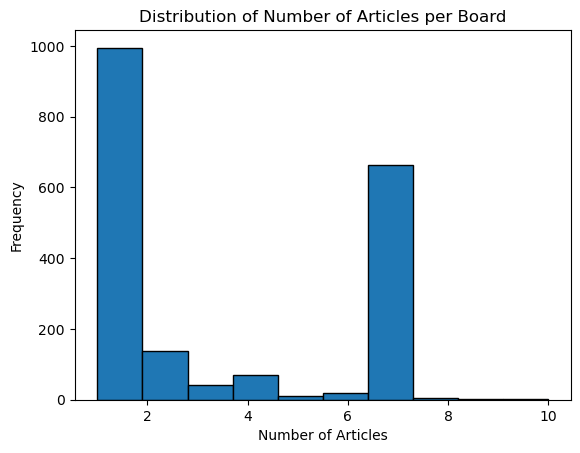

In [145]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(sorted_df['Number_Articles'], bins=10, edgecolor='black')
plt.title('Distribution of Number of Articles per Board')
plt.xlabel('Number of Articles')
plt.ylabel('Frequency')
plt.show()


## Sampling Articles Per Board
- After getting number of articles to be assigned to each board, and after extracting a fixed number of articles from all boards, in this section we then sample articles from the fixed number of articles based on the number of articles per board.

In [154]:

#sampling function that performs the following:
#Iterates through the first DataFrame (which contains BoardID and Number_Articles)
# For each BoardID in the first DataFrame, it will filter the corresponding rows from the second DataFrame (which contains articles).
# Randomly selects the specified number of articles from the second DataFrame for each BoardID
# Collects the results into a new DataFrame with the selected articles.

def select_random_articles(df_board_articles, df_articles):
    # Initialize an empty list to hold the output data
    selected_articles = []

    # Iterate over each row in the df_board_articles DataFrame
    for index, row in df_board_articles.iterrows():
        #print(row)
        board_id = row['BoardIDs']  # Get the current BoardID
        num_articles_to_select = int(row['Number_Articles'])  # Get the number of articles to select

        # Filter the second dataframe (df_articles) for rows that match the current BoardID
        matching_articles = df_articles[df_articles['BoardID'] == board_id]

        # If there are more articles available than needed, randomly select them
        if len(matching_articles) >= num_articles_to_select:
            selected_articles_for_board = matching_articles.sample(n=num_articles_to_select, random_state=42)
        else:
            # If not enough articles, select all available articles
            selected_articles_for_board = matching_articles

        # Append the selected articles to the result list
        selected_articles.append(selected_articles_for_board)

    # Concatenate the list of selected articles into a single DataFrame
    result_df = pd.concat(selected_articles).reset_index(drop=True)

    return result_df

# Example usage:

# copy dataframe of BoardIDs and Number of Articles
df_board_articles = sorted_df.copy()

# copy dataframe of articles and boardIDS
articles_df  = final_df.copy()

#print(articles_df.head())

# Call the function
result_df = select_random_articles(df_board_articles, articles_df)

# Display the result
print(result_df.head())


  _id                                           fullText  \
0      El neurólogo Conrado Estol dio sus impresiones...   
1      Сырский объяснил, почему провели Курскую опера...   
2      म्याग्दी : नेपाल विद्युत् प्राधिकरणद्वारा म्या...   
3      Released 09/09/2024. Today is World EV Day, an...   
4      Zacapu, Michoacán (MiMorelia.com).- Un adolesc...   

                                         description  \
0  El neurólogo Conrado Estol dio sus impresiones...   
1  Сырский объяснил, почему провели Курскую опера...   
2  म्याग्दी : नेपाल विद्युत् प्राधिकरणद्वारा म्या...   
3  Released 09/09/2024. Today is World EV Day, an...   
4  Zacapu, Michoacán (MiMorelia.com).- Un adolesc...   

                                               title  \
0  Conrado Estol habló del cuadro que sufrió Guil...   
1  Курская операция помогла в защите Покровска: С...   
2  डाँडाखेत–राहुघाट प्रसारण लाइन : सकिनुपर्ने समय...   
3  MIL-OSI Australia: New electric vehicles join ...   
4  Michoacán: con 17 a

In [157]:
# Count number of articles that are sampled from the dataset based on the sampling number. 
result_df.groupby('BoardID').agg({'BoardID': 'count'})

,BoardID
BoardID,
2056,1
2057,1
2067,1
2088,1
2089,1
2092,7
2095,1
2134,3
2135,8


## TODO
- Write a test case to always check if the number of articles sampled from the dataset are same as the number of articles that are supposed to be sampled. That is, we have 2 data frames. One contains articles in large numbers collected for all boards in the sample frame. The other dataframe contains information on the sampling strategy. That is, the number of articles to be sampled per board. 

In [163]:
# check if sampled articles match articles to be sample(by observation)
rw = df_board_articles[df_board_articles['BoardIDs'] == 2189]

print(rw)

    BoardIDs  Number_Articles
14      2189              6.0


In [164]:
# check sampled articles belonging to Board 2189
articles_2189 = result_df[result_df['BoardID'] == 2189]
articles_2189

,_id,fullText,description,title,rssItemId,BoardID
22,,El neurólogo Conrado Estol dio sus impresiones...,El neurólogo Conrado Estol dio sus impresiones...,Conrado Estol habló del cuadro que sufrió Guil...,lanacion-AR-a155f6686d3bee927bea478182db6810,2189
23,,"Es dauerte mehr als sechs Wochen, bis die Führ...","Es dauerte mehr als sechs Wochen, bis die Führ...",GASTKOMMENTAR - Der erste «heisse» Konflikt de...,NZZ-3accb9d9c6e0d31a0c3d2289c0f64491,2189
24,,Die negativen Schlagzeilen aus der österreichi...,Die negativen Schlagzeilen aus der österreichi...,Wirtschaft im Niedergang: Österreich hat die K...,NZZ-715ecf235c73ddb619d73953df0f066e,2189
25,,"Released 09/09/2024. Today is World EV Day, an...","Released 09/09/2024. Today is World EV Day, an...",MIL-OSI Australia: New electric vehicles join ...,foreignaffairs-nz-e33cf20a0241990b1ca09872214d...,2189
26,,La gran cantidad de sismos que recibe nuestro ...,La gran cantidad de sismos que recibe nuestro ...,"Temblor en Chile hoy, lunes 9 de setiembre – ú...",gestion-3162277cc5d3c686f4974a222cd00e95,2189
27,,-Bitmeyecek yavrum. Nerede görülmüş? -Yani Koç...,-Bitmeyecek yavrum. Nerede görülmüş? -Yani Koç...,Annecim CHP gelince kapitalizm bitecek mi?,birgun-5824f7594314ab6390372d17369722b4,2189


In [165]:
# check  original articles from ES belonging to Board 2189 to compare if they were truly sampled from 2189

all_articles_2189 = articles_df[articles_df['BoardID']== 2189]

all_articles_2189


,_id,fullText,description,title,rssItemId,BoardID
280,,El neurólogo Conrado Estol dio sus impresiones...,El neurólogo Conrado Estol dio sus impresiones...,Conrado Estol habló del cuadro que sufrió Guil...,lanacion-AR-a155f6686d3bee927bea478182db6810,2189
281,,"Released 09/09/2024. Today is World EV Day, an...","Released 09/09/2024. Today is World EV Day, an...",MIL-OSI Australia: New electric vehicles join ...,foreignaffairs-nz-e33cf20a0241990b1ca09872214d...,2189
282,,"BERLIN Sept. 9, 2024 /PRNewswire/ -- On Septem...","BERLIN Sept. 9, 2024 /PRNewswire/ -- On Septem...",CHiQ Awarded TÜV Carbon Verification Statement...,taiwannews-9f6d90a521a3a9b2d63355c562a1aacb,2189
283,,Programul naţional ”Şcoala altfel” şi Programu...,Programul naţional ”Şcoala altfel” şi Programu...,An şcolar 2024-2025. Când au elevii următoarea...,romaniatv-32de0e8eaedc7c58a435d9ad4d63aebb,2189
284,,"In Italia 27 focolai attivi, uno nel Piacentin...","In Italia 27 focolai attivi, uno nel Piacentin...",Incubo peste suina. Maiali da abbattere se ven...,ilrestodelcarlino-f7778b813fb0287d7b56512562ad...,2189
285,,-Bitmeyecek yavrum. Nerede görülmüş? -Yani Koç...,-Bitmeyecek yavrum. Nerede görülmüş? -Yani Koç...,Annecim CHP gelince kapitalizm bitecek mi?,birgun-5824f7594314ab6390372d17369722b4,2189
286,,Nach ersten Gehversuchen mit E-Government-Anwe...,Nach ersten Gehversuchen mit E-Government-Anwe...,GASTKOMMENTAR - E-ID – Schlüssel zur digitalen...,NZZ-f9fe039e44a4b6feb9b376bdd29a0113,2189
287,,"«Wir haben überall Sparpotenzial gefunden», ve...","«Wir haben überall Sparpotenzial gefunden», ve...",Eine einsatzfähige Armee per 2050?,NZZ-e5dcca7cbced899aa9a0ce12f2931b8e,2189
288,,La gran cantidad de sismos que recibe nuestro ...,La gran cantidad de sismos que recibe nuestro ...,"Temblor en Chile hoy, lunes 9 de setiembre – ú...",gestion-3162277cc5d3c686f4974a222cd00e95,2189
289,,"Zacapu, Michoacán (MiMorelia.com).- Un adolesc...","Zacapu, Michoacán (MiMorelia.com).- Un adolesc...","Michoacán: con 17 años, muere tras chocar en m...",mimorelia-mx-2d8d331102fbd92068a1fe4ff6b81684,2189


##  Conclusion
- I can pull articles from the Elastics and sample them based on our sampling strategy.

## Optimization
- Find a way of modifying queries such that the call to ES is minimized.
- Reduce the number of boards in the sampling frame by increasing the filter of number of activities per board since 2023

####  END 



## Retrieve Articles

In [166]:
search_result_7031 = client.search(
    index="eios-items_2023-12",
    query={
        "bool": {
            "must": [
                {
                    "range": {
                        "pubDate": {"gte": "2023-12-01T00:00:00", "lte": "2023-12-14T00:00:00"}
                    }
                },
                {
                    "terms": {
                        "_name": "tags-0",
                        "tags": [
                            "l:Arenavirus",
                            "l:Crimean-CongoHF",
                            "l:EbolaHemorrhagicFever",
                            "l:Filovirus",
                            "l:HemorrhagicFever",
                            "l:LassaFever",
                            "l:Lujo",
                            "l:MarburgHemorrhagicFever",
                        ],
                    }
                },
            ]
        }
    },
    _source=[
        "description",
        "fullText",
        "affectedCountriesIso",
        "title",
        "languageCode",
        "triggers",
        "pubDate",
    ],
    size=10,
)

c:\Users\NkwawirB\.conda\envs\data_explore\Lib\site-packages\urllib3\connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fw-bln.rki.local'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\NkwawirB\.conda\envs\data_explore\Lib\site-packages\elasticsearch\connection\base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [167]:
len(search_result_7031["hits"]["hits"])

10

In [72]:

#Extract data from a given index in Elastic search from a specific board.

def retrieve_and_save_elasticsearch_data(index_name, tags_query, size):

    """
    index_name (str): specifies the Elastic search index for which articles will be extracted
    tags_query
    
    """

    

    # Define the range query for the 'pubDate' field
    date_range_query = Q("range", **{
        "pubDate": {
            "gte": "2024-09-09T00:00:00",
            "lte": "2024-09-24T23:59:59"
        }
    })

    # Define the terms query for the 'tags' field based on input tags_query
    tags_query_elasticsearch =  tags_query

    # Combine the queries using a bool must query
    combined_query = Q("bool", must=[date_range_query, tags_query_elasticsearch])

    # Add the combined query to the search object
    search = Search(using=client, index=index_name).query(combined_query)

    # Specify the fields to include in the results
    fields_to_include = [
        "title", "translatedTitle", "description", "translatedDescription",
        "fullText", "translatedText", "rssItemId", "abstractiveSummary", 
        "translatedAbstractiveSummary"
    ]
    search = search.source(includes=fields_to_include)

    # Set the size of results to retrieve based on input size
    search = search[0:size]

    # Execute the search
    response = search.execute()

    # Convert the response hits to a list of dictionaries
    response_data = [hit.to_dict() for hit in response]

    # Extract the required columns for the CSV
    filtered_data = [{
        "_id": hit.get("_id", ""),
        "fullText": hit.get("fullText", ""),
        "description": hit.get("description", ""),
        "title": hit.get("title", ""),
        "rssItemId": hit.get("rssItemId", "")
    } for hit in response_data]

    # Create a DataFrame from the filtered data
    df = pd.DataFrame(filtered_data, columns=["_id", "fullText", "description", "title", "rssItemId"])

    #output_filename = f"uelasticsearch_results.csv"

    return df




# Read the Excel file
excel_file_path = "../data/excel_data_sampling/saved_query_board_activity_summary_v0.xlsx"  # Adjust the path as needed
saved_query_df = pd.read_excel(excel_file_path)
saved_query_df.head()

# Safely convert string lists to actual lists
saved_query_df['BoardTags(SQ)'] = saved_query_df['BoardTags(SQ)'].apply(ast.literal_eval)  


# Loop over each row in the DataFrame and retrieve data for each set of tags
all_data = []

i  = 0
# Specify the index
index_name = "eios-items_2024-09"

for index, row in saved_query_df.iterrows():

    if i == 5:
        break

    board_id = row['BoardID']
    tags = row['BoardTags(SQ)']  # Tags for the specific board
    
    # Create a terms query for the tags
    tags_query_cholera = Q("terms", **{
        "tags": tags
    })

    #print(tags_query_cholera)

     # Retrieve the data (Assuming retrieve_and_save_elasticsearch_data is a function that does the ES query)
    sample_df = retrieve_and_save_elasticsearch_data(index_name, tags_query_cholera, size=5)

    #print(sample_df)

    # Add a BoardID column to the retrieved data
    sample_df['BoardID'] = board_id

    # Append to all_data list
    all_data.append(sample_df)

    #print(all_data)

    i = 1 +i
# Concatenate all the data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Save the final DataFrame to a CSV file
final_df.to_csv(sample_filename, index=False, encoding='utf-8')

print(f"Data saved to {sample_filename}")
print(final_df)


c:\Users\NkwawirB\.conda\envs\data_explore\Lib\site-packages\urllib3\connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fw-bln.rki.local'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\NkwawirB\.conda\envs\data_explore\Lib\site-packages\elasticsearch\connection\base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
c:\Users\NkwawirB\.conda\envs\data_explore\Lib\site-packages\urllib3\connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fw-bln.rki.local'. Adding certificate verification is strongly advised. See: https://u

Data saved to elasticsearch_results_combined.csv
   _id                                           fullText  \
0       “While it is possible that other cases may yet...   
1       University of Arizona researchers seeking appr...   
2       Today's case is the fifth confirmed case of mp...   
3       EN E-001364/2024 Answer given by Ms Kyriakides...   
4       El toldo que cubre la reja de hierro en zigzag...   
5       “While it is possible that other cases may yet...   
6       University of Arizona researchers seeking appr...   
7       Today's case is the fifth confirmed case of mp...   
8       EN E-001364/2024 Answer given by Ms Kyriakides...   
9       El toldo que cubre la reja de hierro en zigzag...   
10      “While it is possible that other cases may yet...   
11      University of Arizona researchers seeking appr...   
12      Today's case is the fifth confirmed case of mp...   
13      EN E-001364/2024 Answer given by Ms Kyriakides...   
14      El toldo que cubre la reja d

c:\Users\NkwawirB\.conda\envs\data_explore\Lib\site-packages\elasticsearch\connection\base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [73]:
final_df

,_id,fullText,description,title,rssItemId,BoardID
0,,“While it is possible that other cases may yet...,“While it is possible that other cases may yet...,Mpox outbreak: Case linked to Queenstown’s Win...,nz-herald-health-4b9642905602d50378701b5d91da5b28,2056
1,,University of Arizona researchers seeking appr...,"Valley Fever -- Arizona, United States. Signif...",University of Arizona researchers seeking appr...,healthmap-8850c41cd925ecf767cebb68f7c40b40,2056
2,,Today's case is the fifth confirmed case of mp...,Today's case is the fifth confirmed case of mp...,9 Sep: Mpox outbreak: new case linked to queen...,nzcity-c2df49590c6a2ee56722d81230b245f0,2056
3,,EN E-001364/2024 Answer given by Ms Kyriakides...,EN E-001364/2024 Answer given by Ms Kyriakides...,Answer to a written question - Legal action ag...,europarl-e5a5b812a17b695a1167313ae84ad871,2056
4,,El toldo que cubre la reja de hierro en zigzag...,El toldo que cubre la reja de hierro en zigzag...,Crisis y miedo en Venezuela intensifican la mi...,uol-a2537e81830aaa4ae4e72e4e81e79ce9,2056
5,,“While it is possible that other cases may yet...,“While it is possible that other cases may yet...,Mpox outbreak: Case linked to Queenstown’s Win...,nz-herald-health-4b9642905602d50378701b5d91da5b28,2057
6,,University of Arizona researchers seeking appr...,"Valley Fever -- Arizona, United States. Signif...",University of Arizona researchers seeking appr...,healthmap-8850c41cd925ecf767cebb68f7c40b40,2057
7,,Today's case is the fifth confirmed case of mp...,Today's case is the fifth confirmed case of mp...,9 Sep: Mpox outbreak: new case linked to queen...,nzcity-c2df49590c6a2ee56722d81230b245f0,2057
8,,EN E-001364/2024 Answer given by Ms Kyriakides...,EN E-001364/2024 Answer given by Ms Kyriakides...,Answer to a written question - Legal action ag...,europarl-e5a5b812a17b695a1167313ae84ad871,2057
9,,El toldo que cubre la reja de hierro en zigzag...,El toldo que cubre la reja de hierro en zigzag...,Crisis y miedo en Venezuela intensifican la mi...,uol-a2537e81830aaa4ae4e72e4e81e79ce9,2057


In [76]:
import ast
import pandas as pd
from elasticsearch_dsl import Search, Q

# Function to extract data from a given index in Elasticsearch for multiple tags
def retrieve_and_save_elasticsearch_data(index_name, combined_tags_query, size):
    """
    index_name (str): specifies the Elasticsearch index for which articles will be extracted
    combined_tags_query: A combined query for multiple tags
    size: the maximum number of records to retrieve
    """

    # Define the range query for the 'pubDate' field
    date_range_query = Q("range", **{
        "pubDate": {
            "gte": "2024-09-09T00:00:00",
            "lte": "2024-09-24T23:59:59"
        }
    })

    # Combine the date range and tags query using a bool query
    combined_query = Q("bool", must=[date_range_query], should=combined_tags_query, minimum_should_match=1)

    # Add the combined query to the search object
    search = Search(using=client, index=index_name).query(combined_query)

    # Specify the fields to include in the results
    fields_to_include = [
        "title", "translatedTitle", "description", "translatedDescription",
        "fullText", "translatedText", "rssItemId", "abstractiveSummary", 
        "translatedAbstractiveSummary"
    ]
    search = search.source(includes=fields_to_include)

    # Set the size of results to retrieve based on input size
    search = search[0:size]

    # Execute the search
    response = search.execute()

    # Convert the response hits to a list of dictionaries
    response_data = [hit.to_dict() for hit in response]

    # Extract the required columns for the final DataFrame
    filtered_data = [{
        "_id": hit.get("_id", ""),
        "fullText": hit.get("fullText", ""),
        "description": hit.get("description", ""),
        "title": hit.get("title", ""),
        "rssItemId": hit.get("rssItemId", "")
    } for hit in response_data]

    # Create a DataFrame from the filtered data
    df = pd.DataFrame(filtered_data, columns=["_id", "fullText", "description", "title", "rssItemId"])

    return df


# Read the Excel file containing the board and tags information
excel_file_path = "../data/excel_data_sampling/saved_query_board_activity_summary_v0.xlsx"  # Adjust the path as needed
saved_query_df = pd.read_excel(excel_file_path)

# Safely convert string lists to actual lists
saved_query_df['BoardTags(SQ)'] = saved_query_df['BoardTags(SQ)'].apply(ast.literal_eval)

# List to hold all tag queries for batch querying
all_tags_queries = []
board_ids = []

# Limit to 5 iterations (or modify according to your needs)
i = 0
max_iterations = 5

# Loop through the DataFrame and prepare the tags query for each board
for index, row in saved_query_df.iterrows():
    if i == max_iterations:
        break

    board_id = row['BoardID']
    tags = row['BoardTags(SQ)']  # Tags for the specific board
    
    # Create a terms query for the tags
    tags_query = Q("terms", **{"tags": tags})
    
    # Append the tags query and the board ID to the respective lists
    all_tags_queries.append(tags_query)
    board_ids.append(board_id)

    i += 1

# Specify the index for querying Elasticsearch
index_name = "eios-items_2024-09"

# Query Elasticsearch once using the combined tags query
combined_df = retrieve_and_save_elasticsearch_data(index_name, all_tags_queries, size=5)

# Assign BoardID to the resulting DataFrame based on matching tags (this requires some form of logic to map results to board IDs)
final_data = []
for board_id in board_ids:
    # Assume logic to filter the results by tags or boardId
    board_df = combined_df.copy()  # Add your logic to match the tags with the correct board
    board_df['BoardID'] = board_id
    final_data.append(board_df)

# Concatenate all the data into a single DataFrame
final_df = pd.concat(final_data, ignore_index=True)

# Save the final DataFrame to a CSV file
sample_filename = "elasticsearch_results_combined.csv"
final_df.to_csv(sample_filename, index=False, encoding='utf-8')

print(f"Data saved to {sample_filename}")
print(final_df)


Data saved to elasticsearch_results_combined.csv
   _id                                           fullText  \
0       “While it is possible that other cases may yet...   
1       Today's case is the fifth confirmed case of mp...   
2       A new case of mpox with a "likely" link to the...   
3       Following vaccination, safety monitoring inclu...   
4       The NHS Covid vaccine scheme will be returning...   
5       “While it is possible that other cases may yet...   
6       Today's case is the fifth confirmed case of mp...   
7       A new case of mpox with a "likely" link to the...   
8       Following vaccination, safety monitoring inclu...   
9       The NHS Covid vaccine scheme will be returning...   
10      “While it is possible that other cases may yet...   
11      Today's case is the fifth confirmed case of mp...   
12      A new case of mpox with a "likely" link to the...   
13      Following vaccination, safety monitoring inclu...   
14      The NHS Covid vaccine scheme

c:\Users\NkwawirB\.conda\envs\data_explore\Lib\site-packages\urllib3\connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fw-bln.rki.local'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\NkwawirB\.conda\envs\data_explore\Lib\site-packages\elasticsearch\connection\base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [78]:
print(all_tags_queries)

[Terms(tags=['l:AEFI']), Terms(tags=['l:AEFI']), Terms(tags=['l:AEFI']), Terms(tags=['l:Vaccination']), Terms(tags=['f:1:My categories', 'f:1:Societal', 'l:AnimalsCoronavirus', 'l:AsymptomaticCoronavirus', 'l:ChildYouthCoronavirus', 'l:ElderlyCoronavirus', 'l:IHRrelated', 'l:IndigenousCoronavirus', 'l:RespiratorySyndrome'])]


In [80]:
# Define the range query for the 'pubDate' field
date_range_query = Q("range", **{
    "pubDate": {
        "gte": "2024-09-09T00:00:00",
        "lte": "2024-09-24T23:59:59"
    }
})


# Combine the date range and tags query using a bool query
combined_query = Q("bool", must=[date_range_query], should=all_tags_queries, minimum_should_match=1)

print(combined_query)


Bool(minimum_should_match=1, must=[Range(pubDate={'gte': '2024-09-09T00:00:00', 'lte': '2024-09-24T23:59:59'})], should=[Terms(tags=['l:AEFI']), Terms(tags=['l:AEFI']), Terms(tags=['l:AEFI']), Terms(tags=['l:Vaccination']), Terms(tags=['f:1:My categories', 'f:1:Societal', 'l:AnimalsCoronavirus', 'l:AsymptomaticCoronavirus', 'l:ChildYouthCoronavirus', 'l:ElderlyCoronavirus', 'l:IHRrelated', 'l:IndigenousCoronavirus', 'l:RespiratorySyndrome'])])


Bool(minimum_should_match=1, must=[Range(pubDate={'gte': '2024-09-09T00:00:00', 'lte': '2024-09-24T23:59:59'})], should=[Terms(tags=['l:AEFI']), Terms(tags=['l:AEFI']), Terms(tags=['l:AEFI']), Terms(tags=['l:Vaccination']), Terms(tags=['f:1:My categories', 'f:1:Societal', 'l:AnimalsCoronavirus', 'l:AsymptomaticCoronavirus', 'l:ChildYouthCoronavirus', 'l:ElderlyCoronavirus', 'l:IHRrelated', 'l:IndigenousCoronavirus', 'l:RespiratorySyndrome'])])


In [77]:
final_df

,_id,fullText,description,title,rssItemId,BoardID
0,,“While it is possible that other cases may yet...,“While it is possible that other cases may yet...,Mpox outbreak: Case linked to Queenstown’s Win...,nz-herald-health-4b9642905602d50378701b5d91da5b28,2056
1,,Today's case is the fifth confirmed case of mp...,Today's case is the fifth confirmed case of mp...,9 Sep: Mpox outbreak: new case linked to queen...,nzcity-c2df49590c6a2ee56722d81230b245f0,2056
2,,"A new case of mpox with a ""likely"" link to the...","A new case of mpox with a ""likely"" link to the...",Mpox outbreak: New case linked to Queenstown's...,gphin-560d76df9d6b48df90b324110cc1971d,2056
3,,"Following vaccination, safety monitoring inclu...","Following vaccination, safety monitoring inclu...","Vaccines, Vol. 12, Pages 1036: Safety and Immu...",mdpi-2b552bef44cbb675c0cf27ce1d075cc5,2056
4,,The NHS Covid vaccine scheme will be returning...,The NHS Covid vaccine scheme will be returning...,Covid vaccine: who is eligible for NHS Covid j...,TheScotsman-361467f9e9c7f5ab6954222cd8016432,2056
5,,“While it is possible that other cases may yet...,“While it is possible that other cases may yet...,Mpox outbreak: Case linked to Queenstown’s Win...,nz-herald-health-4b9642905602d50378701b5d91da5b28,2057
6,,Today's case is the fifth confirmed case of mp...,Today's case is the fifth confirmed case of mp...,9 Sep: Mpox outbreak: new case linked to queen...,nzcity-c2df49590c6a2ee56722d81230b245f0,2057
7,,"A new case of mpox with a ""likely"" link to the...","A new case of mpox with a ""likely"" link to the...",Mpox outbreak: New case linked to Queenstown's...,gphin-560d76df9d6b48df90b324110cc1971d,2057
8,,"Following vaccination, safety monitoring inclu...","Following vaccination, safety monitoring inclu...","Vaccines, Vol. 12, Pages 1036: Safety and Immu...",mdpi-2b552bef44cbb675c0cf27ce1d075cc5,2057
9,,The NHS Covid vaccine scheme will be returning...,The NHS Covid vaccine scheme will be returning...,Covid vaccine: who is eligible for NHS Covid j...,TheScotsman-361467f9e9c7f5ab6954222cd8016432,2057
